In [1]:
import warnings
import sys
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import math #needed for definition of pi

np.set_printoptions(precision=3, suppress=True, linewidth=100)

class MultLat(object):
    def __init__(self, latsPath):
        self.reqTimes = np.empty([0,0])
        # for idx in [{1},]:
        # fileName = latsPath+"/lats-"+str(idx)+".bin"
        fileName = latsPath+"/lats-1.bin"
#             print("looking for: ", fileName)
        # fileName = join(latsPath,'lats.bin')
        if os.path.exists(fileName):
            f = open(fileName, 'rb')
            a = np.fromfile(f, dtype=np.uint64) # a will be 1-D array of all data
            self.reqTimes = np.append(self.reqTimes, a, axis=None)
            # np.append(self.reqTimes, a.reshape((a.shape[0]//3, 3)), axis=None)
            # self.reqTimes = a.reshape((a.shape[0]//3, 3)) # transfer into 2-D array
            f.close()
        else:
            print("not found in this dir :", fileName)
        
        self.reqTimes = self.reqTimes.reshape((self.reqTimes.shape[0]//4, 4))


    def parseQueueTimes(self):
        return self.reqTimes[:, 0]

    def parseSvcTimes(self):
        return self.reqTimes[:, 1]

    def parseSojournTimes(self):
        return self.reqTimes[:, 2]
    
    def parseSpinTimes(self):
        return self.reqTimes[:, 3]

def getMultLatPct(latsFolder, spinN):
    # print(latsFolder)
    assert os.path.exists(latsFolder)
    
    latsObj = MultLat(latsFolder)

    qTimes = [l/1e6 for l in latsObj.parseQueueTimes()]
    svcTimes = [l/1e6 for l in latsObj.parseSvcTimes()]
    sjrnTimes = [l/1e6 for l in latsObj.parseSojournTimes()]
    spinTimes = latsObj.parseSpinTimes()
    f = open('lats.txt','w')

    f.write('%12s | %12s | %12s | %12s\n\n' \
            % ('QueueTimes', 'ServiceTimes', 'SojournTimes', 'SpinTimes'))

    for (q, svc, sjrn, spin) in zip(qTimes, svcTimes, sjrnTimes, spinTimes):
        f.write("%12s | %12s | %12s | %12s\n" \
                % ('%.3f' % q, '%.3f' % svc, '%.3f' % sjrn, '%.3f' % spin))
    f.close()

    sjrn95th = stats.scoreatpercentile(sjrnTimes, 95)
    sjrn99th = stats.scoreatpercentile(sjrnTimes, 99)
    sjrnMean = stats.tmean(sjrnTimes)
    sjrnMax = max(sjrnTimes)
    sjrn95Mean = stats.tmean(sjrnTimes, (sjrn95th, sjrnMax))
    sjrn99Mean = stats.tmean(sjrnTimes, (sjrn99th, sjrnMax))

    svc95th = stats.scoreatpercentile(svcTimes, 95)
    svc99th = stats.scoreatpercentile(svcTimes, 99)
    svcMean = stats.tmean(svcTimes)
    svcMax = max(svcTimes)
    svc95Mean = stats.tmean(svcTimes, (svc95th, svcMax))
    svc99Mean = stats.tmean(svcTimes, (svc99th, svcMax))


    try:
        meanSpin = stats.tmean(spinTimes, limits=(1,int(spinN)-1))
    except ValueError:
        # print("only 0 and max here.")
        meanSpin = 0
    # meanSpin = stats.tmean(trim(spinTimes,(1,int(spinN)-1)))
    # meanSpin = stats.tmean(spinTimes, limits=(1,int(spinN)-1))
    # spin95 = stats.scoreatpercentile(spinTimes, 95, limit=(1,int(spinN)-1))
    # spin99 = stats.scoreatpercentile(spinTimes, 99, limit=(1,int(spinN)-1))
    maxSpinP = stats.percentileofscore(spinTimes, int(spinN))
    spin0 = stats.percentileofscore(spinTimes, 0, kind="weak")
    spinMax = stats.percentileofscore(spinTimes, int(spinN), kind="strict")
    # print('mean: {:.3f} ms | 95th: {:.3f} ms | 99th: {:.3f} ms; svc mean: {:.3f} ms | 95th: {:.3f} ms | 99th: {:.3f} ms'.format(meanLat, p95, p99, svcMean, svc95, svc99))
    # print ("round mean: %.3f ms | 95th: %.3f ms | 99th: %.3f ms | service mean: %.3f ms | 95th: %.3f ms | 99th: %.3f ms | spin mean: %.3f cycles | %% at 0: %.3f | %% at max : %.3f | %% between: %.3f " \
    #             % (meanLat,p95, p99, svcMean, svc95, svc99, meanSpin, spin0, spinMax, spinMax-spin0))
    return np.asarray([sjrnMean, sjrn95Mean, sjrn99Mean, svcMean, svc95Mean, svc99Mean])

def combineFolder(latsFolder, qps, spin):
    results = np.empty((len(qps), 6))
    # print("combined matrix:")
    rdx = 0
    for f in qps:
        # print(f)
        results[rdx]=getMultLatPct(join(latsFolder,f), spin)
        rdx = rdx + 1
    # for index in range(5):  
    #     print('{} mean: {:.3f} ms | 95th: {:.3f} ms | 99th: {:.3f} ms'.format((index+1)*2, results[index,0], results[index,1], results[index,2]))
    swaped = np.swapaxes(results,0,1)
    # print(repr(results))
    np.set_printoptions(precision=3)
    return swaped
    # print(str(latsFolder)+"="+ np.array2string(swaped[:,:], separator=','))
    # return results

[[  5.395,  5.208,  5.587,  5.923,  6.377,  7.319,  9.057, 11.448, 37.06 ,
  315.861],
 [ 11.555, 11.477, 11.471, 11.858, 12.501, 15.236, 20.254, 26.693,113.582,
  510.155],
 [ 18.203, 11.657, 14.881, 15.545, 16.892, 25.176, 36.684, 39.966,162.622,
  523.841],
 [  5.204,  4.993,  5.118,  5.102,  5.119,  5.126,  5.179,  5.105,  5.178,
    5.225],
 [ 11.416, 11.351, 10.727, 11.398, 11.391, 11.334, 11.361, 11.361, 11.372,
   11.403],
 [ 12.936, 11.532, 12.652, 12.025, 12.389, 12.313, 12.705, 11.544, 11.581,
   11.63 ]]


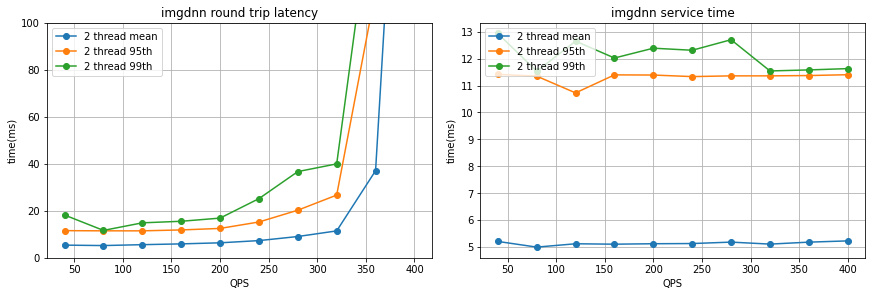

In [5]:
# imgdnn1_dir = "/home/zohan/tailbench/results/imgdnn-1"
# imgdnn1_qps = ("40","80","100","120","160","200","240","280","320","340","380","420","460","500")
# imgdnn1_data = combineFolder(imgdnn1_dir,imgdnn1_qps)

imgdnn2_dir = "/home/zohan/microbench/result-microimgdnn-2/"
imgdnn2_qps = ("40","80","120","160","200","240","280","320","360","400")
imgdnn2_data = combineFolder(imgdnn2_dir,imgdnn2_qps,2000)
print(np.array2string(imgdnn2_data[:,:], separator=','))
# imgdnn4_dir = "/home/zohan/tailbench/results/imgdnn-4"
# imgdnn4_qps = ("40","80","100","120","160","200","240","280","320","340","380","420","460","500")
# imgdnn4_data = combineFolder(imgdnn4_dir,imgdnn4_qps)

plt.rcParams['figure.figsize'] = [12, 4]

# x = np.arange(len(imgdnn2_qps)) # the label locations

# plt.subplot(211)
# labels1 = list(int(i) for i in imgdnn1_qps)
labels2 = list(int(i) for i in imgdnn2_qps)
# labels4 = list(int(i) for i in imgdnn4_qps)

fig, (ax00,ax01) = plt.subplots(ncols=2, nrows=1, constrained_layout=True)

# ax00.plot(labels1, imgdnn1_data[0], ':', label='1 thread mean')
# ax00.plot(labels1, imgdnn1_data[1], ':', label='1 thread 95th')
# ax00.plot(labels1, imgdnn1_data[2], ':', label='1 thread 99th')

ax00.plot(labels2, imgdnn2_data[0], 'o-', label='2 thread mean')
ax00.plot(labels2, imgdnn2_data[1], 'o-', label='2 thread 95th')
ax00.plot(labels2, imgdnn2_data[2], 'o-', label='2 thread 99th')

# ax00.plot(labels4, imgdnn4_data[0], '--', label='4 thread mean')
# ax00.plot(labels4, imgdnn4_data[1], '--', label='4 thread 95th')
# ax00.plot(labels4, imgdnn4_data[2], '--', label='4 thread 99th')

# ax01.plot(labels1, imgdnn1_data[3], ':', label='1 thread mean')
# ax01.plot(labels1, imgdnn1_data[4], ':', label='1 thread 95th')
# ax01.plot(labels1, imgdnn1_data[5], ':', label='1 thread 99th')

ax01.plot(labels2, imgdnn2_data[3], 'o-', label='2 thread mean')
ax01.plot(labels2, imgdnn2_data[4], 'o-', label='2 thread 95th')
ax01.plot(labels2, imgdnn2_data[5], 'o-', label='2 thread 99th')

# ax01.plot(labels4, imgdnn4_data[3], '--', label='4 thread mean')
# ax01.plot(labels4, imgdnn4_data[4], '--', label='4 thread 95th')
# ax01.plot(labels4, imgdnn4_data[5], '--', label='4 thread 99th')

ax00.legend(loc='upper left')
ax01.legend(loc='upper left')
ax00.set_ylim(0, 100)
# ax00.set_xlim(0, 2500)
# ax02.set_xlim(6, 14)
# plt.yscale('log')
ax00.set_ylabel('time(ms)')
ax00.set_xlabel('QPS')
ax00.set_title('imgdnn round trip latency')

ax01.set_ylabel('time(ms)')
ax01.set_xlabel('QPS')
ax01.set_title('imgdnn service time')

ax00.grid(True)
ax01.grid(True)
# fig.suptitle('1.3 non critical + 0.2ms critical svc time, sweeping sleep time and probability', fontsize=16)
plt.show()

[[  5.154,  5.677,  6.9  ,  7.955, 12.003, 59.931],
 [  7.909,  9.506, 13.191, 16.08 , 27.807,131.462],
 [ 10.668, 11.559, 22.913, 22.356, 35.043,152.399],
 [  4.605,  4.772,  5.002,  5.081,  5.245,  5.415],
 [  6.192,  6.704,  7.091,  7.087,  7.103,  7.097],
 [  7.191,  7.565,  8.326,  7.668,  7.526,  7.142]]


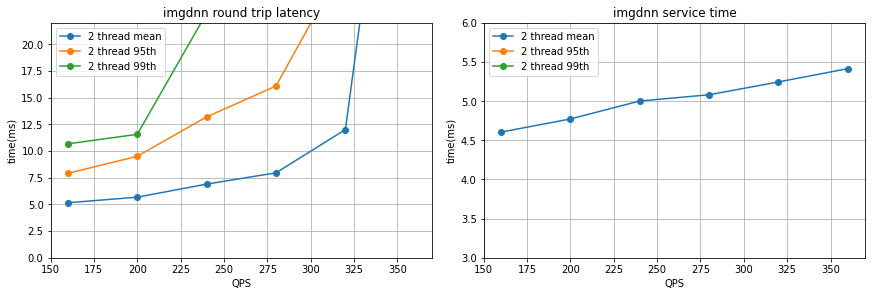

In [11]:
# imgdnn1_dir = "/home/zohan/tailbench/results/imgdnn-1"
# imgdnn1_qps = ("40","80","100","120","160","200","240","280","320","340","380","420","460","500")
# imgdnn1_data = combineFolder(imgdnn1_dir,imgdnn1_qps)

imgdnn2_dir = "/home/zohan/microbench/result-microimgdnn"
imgdnn2_qps = ("160","200","240","280","320","360")
imgdnn2_data = combineFolder(imgdnn2_dir,imgdnn2_qps,2000)
print(np.array2string(imgdnn2_data[:,:], separator=','))
# imgdnn4_dir = "/home/zohan/tailbench/results/imgdnn-4"
# imgdnn4_qps = ("40","80","100","120","160","200","240","280","320","340","380","420","460","500")
# imgdnn4_data = combineFolder(imgdnn4_dir,imgdnn4_qps)

plt.rcParams['figure.figsize'] = [12, 4]

# x = np.arange(len(imgdnn2_qps)) # the label locations

# plt.subplot(211)
# labels1 = list(int(i) for i in imgdnn1_qps)
labels2 = list(int(i) for i in imgdnn2_qps)
# labels4 = list(int(i) for i in imgdnn4_qps)

fig, (ax00,ax01) = plt.subplots(ncols=2, nrows=1, constrained_layout=True)

# ax00.plot(labels1, imgdnn1_data[0], ':', label='1 thread mean')
# ax00.plot(labels1, imgdnn1_data[1], ':', label='1 thread 95th')
# ax00.plot(labels1, imgdnn1_data[2], ':', label='1 thread 99th')

ax00.plot(labels2, imgdnn2_data[0], 'o-', label='2 thread mean')
ax00.plot(labels2, imgdnn2_data[1], 'o-', label='2 thread 95th')
ax00.plot(labels2, imgdnn2_data[2], 'o-', label='2 thread 99th')

# ax00.plot(labels4, imgdnn4_data[0], '--', label='4 thread mean')
# ax00.plot(labels4, imgdnn4_data[1], '--', label='4 thread 95th')
# ax00.plot(labels4, imgdnn4_data[2], '--', label='4 thread 99th')

# ax01.plot(labels1, imgdnn1_data[3], ':', label='1 thread mean')
# ax01.plot(labels1, imgdnn1_data[4], ':', label='1 thread 95th')
# ax01.plot(labels1, imgdnn1_data[5], ':', label='1 thread 99th')

ax01.plot(labels2, imgdnn2_data[3], 'o-', label='2 thread mean')
ax01.plot(labels2, imgdnn2_data[4], 'o-', label='2 thread 95th')
ax01.plot(labels2, imgdnn2_data[5], 'o-', label='2 thread 99th')

# ax01.plot(labels4, imgdnn4_data[3], '--', label='4 thread mean')
# ax01.plot(labels4, imgdnn4_data[4], '--', label='4 thread 95th')
# ax01.plot(labels4, imgdnn4_data[5], '--', label='4 thread 99th')

ax00.legend(loc='upper left')
ax01.legend(loc='upper left')
ax00.set_ylim(0, 22)
ax01.set_ylim(3, 6)
# ax00.set_xlim(0, 2500)
# ax02.set_xlim(6, 14)
# plt.yscale('log')
ax00.set_ylabel('time(ms)')
ax00.set_xlabel('QPS')
ax00.set_title('imgdnn round trip latency')

ax01.set_ylabel('time(ms)')
ax01.set_xlabel('QPS')
ax01.set_title('imgdnn service time')

ax00.grid(True)
ax01.grid(True)
# fig.suptitle('1.3 non critical + 0.2ms critical svc time, sweeping sleep time and probability', fontsize=16)
plt.show()

[[  1.88 ,  2.067,  2.852,  4.465, 17.025,499.351],
 [  4.399,  6.167, 13.547, 23.605, 56.947,912.807],
 [ 10.656, 13.929, 25.483, 34.028, 66.699,920.82 ],
 [  1.638,  1.622,  1.663,  1.63 ,  1.594,  1.593],
 [  3.53 ,  3.207,  4.174,  3.704,  3.057,  3.129],
 [  9.285,  7.716, 12.81 , 10.902,  8.322,  8.816]]


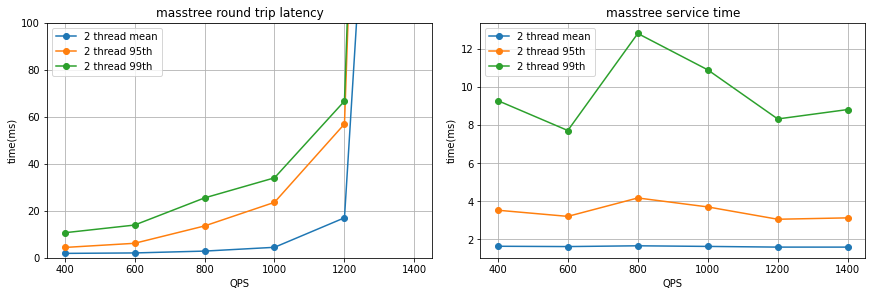

In [3]:
# masstree1_dir = "/home/zohan/tailbench/results/masstree-1"
# masstree1_qps = ("40","80","100","120","160","200","240","280","320","340","380","420","460","500")
# masstree1_data = combineFolder(masstree1_dir,masstree1_qps)

masstree2_dir = "/home/zohan/microbench/result-dist/38000-2-900-600"
masstree2_qps = ("400","600","800","1000","1200","1400")
masstree2_data = combineFolder(masstree2_dir,masstree2_qps,2000)
print(np.array2string(masstree2_data[:,:], separator=','))

# masstree4_dir = "/home/zohan/microbench/result-micromasstree-4"
# masstree4_qps = ("400","500","600","700","800","900","1000","1100","1200","1300")
# masstree4_data = combineFolder(masstree4_dir,masstree4_qps,2000)
# print(np.array2string(masstree4_data[:,:], separator=','))

plt.rcParams['figure.figsize'] = [12, 4]

# x = np.arange(len(masstree2_qps)) # the label locations

# plt.subplot(211)
# labels1 = list(int(i) for i in masstree1_qps)
labels2 = list(int(i) for i in masstree2_qps)
# labels4 = list(int(i) for i in masstree4_qps)

fig, (ax00,ax01) = plt.subplots(ncols=2, nrows=1, constrained_layout=True)

# ax00.plot(labels1, masstree1_data[0], ':', label='1 thread mean')
# ax00.plot(labels1, masstree1_data[1], ':', label='1 thread 95th')
# ax00.plot(labels1, masstree1_data[2], ':', label='1 thread 99th')

ax00.plot(labels2, masstree2_data[0], 'o-', label='2 thread mean')
ax00.plot(labels2, masstree2_data[1], 'o-', label='2 thread 95th')
ax00.plot(labels2, masstree2_data[2], 'o-', label='2 thread 99th')

# ax00.plot(labels4, masstree4_data[0], '--', label='4 thread mean')
# ax00.plot(labels4, masstree4_data[1], '--', label='4 thread 95th')
# ax00.plot(labels4, masstree4_data[2], '--', label='4 thread 99th')

# ax01.plot(labels1, masstree1_data[3], ':', label='1 thread mean')
# ax01.plot(labels1, masstree1_data[4], ':', label='1 thread 95th')
# ax01.plot(labels1, masstree1_data[5], ':', label='1 thread 99th')

ax01.plot(labels2, masstree2_data[3], 'o-', label='2 thread mean')
ax01.plot(labels2, masstree2_data[4], 'o-', label='2 thread 95th')
ax01.plot(labels2, masstree2_data[5], 'o-', label='2 thread 99th')

# ax01.plot(labels4, masstree4_data[3], '--', label='4 thread mean')
# ax01.plot(labels4, masstree4_data[4], '--', label='4 thread 95th')
# ax01.plot(labels4, masstree4_data[5], '--', label='4 thread 99th')

ax00.legend(loc='upper left')
ax01.legend(loc='upper left')
# ax00.set_ylim(0, 22)
ax00.set_ylim(0, 100)
# ax01.set_ylim(3, 6)
# ax00.set_xlim(0, 2500)
# ax02.set_xlim(6, 14)
# plt.yscale('log')
ax00.set_ylabel('time(ms)')
ax00.set_xlabel('QPS')
ax00.set_title('microbench round trip latency')

ax01.set_ylabel('time(ms)')
ax01.set_xlabel('QPS')
ax01.set_title('microbench service time')

ax00.grid(True)
ax01.grid(True)
# fig.suptitle('1.3 non critical + 0.2ms critical svc time, sweeping sleep time and probability', fontsize=16)
plt.show()

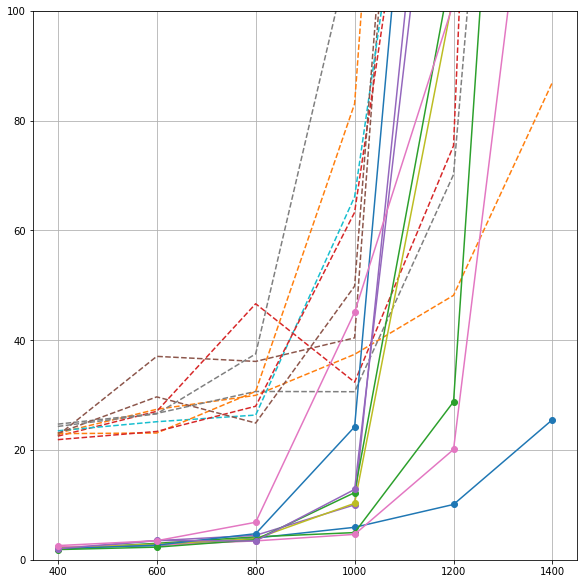

In [251]:
plt.rcParams['figure.figsize'] = [8, 8]
fig, ax00 = plt.subplots(ncols=1, nrows=1, constrained_layout=True)

base_dir = "/home/zohan/microbench/result-dist"
masstree_qps = ("400","600","800","1000","1200","1400")
labels = list(int(i) for i in masstree_qps)

for stime in (20000, ):
    for sprob in (30,):
        for nonblockT in (400,500,600):
            for blockT in (400,500,600):
                affix=str(stime)+"-"+str(sprob)+"-"+str(nonblockT)+"-"+str(blockT)
                datapath=join(base_dir,affix)
                # print(datapath)
                masstree_data = combineFolder(datapath,masstree_qps,2000)
                ax00.plot(labels, masstree_data[0], 'o-', label=affix+"-mean")
                # ax00.plot(labels, masstree_data[1], ':', label=affix+"-95th")
                ax00.plot(labels, masstree_data[2], '--', label=affix+"-99th")

# for affix in ("")
#     # affix=str(stime)+"-"+str(sprob)+"-"+str(nonblockT)+"-"+str(blockT)
#     datapath=join(base_dir,affix)
#     masstree_data = combineFolder(datapath,masstree_qps,2000)
#     ax00.plot(labels, masstree_data[0], 'o-', label=affix+"-mean")
#     ax00.plot(labels, masstree_data[2], '--', label=affix+"-99th")
#     print(np.array2string(masstree_data[:,:], separator=','))

# ax00.legend(loc='upper left')
# ax01.legend(loc='upper left')
ax00.set_ylim(0, 100)
# ax00.set_ylabel('time(ms)')
# ax00.set_xlabel('QPS')
# ax00.set_title('masstree round trip latency')
ax00.grid(True)
# ax01.grid(True)
plt.show()